# Мэтчинг товаров маркетплейса

В качестве исходных данных дается набор векторов (около 3 млн), выборка для тренировки и валидации модели. В выборках тренировки и валидации дан набор векторов и соответствующие нгаиболее "близкие" векторы из базового набора.

**Задача:** разработать алгоритм, который будет для заданного вектора выдавать наиболее близкий и базового набора.

In [126]:
from catboost import CatBoostClassifier
import faiss
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt
from mlxtend.classifier import StackingClassifier
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from tqdm.notebook import tqdm

# Загрузка данных

Base

In [2]:
df_base = pd.read_csv("base.csv", index_col=0)
print(df_base.shape)
df_base.head()

(2918139, 72)


,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [3]:
dims = df_base.shape[1]

Train

In [4]:
df_train = pd.read_csv("train.csv", index_col=0)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


In [5]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

## Исследование данных

Распределение каждого признака

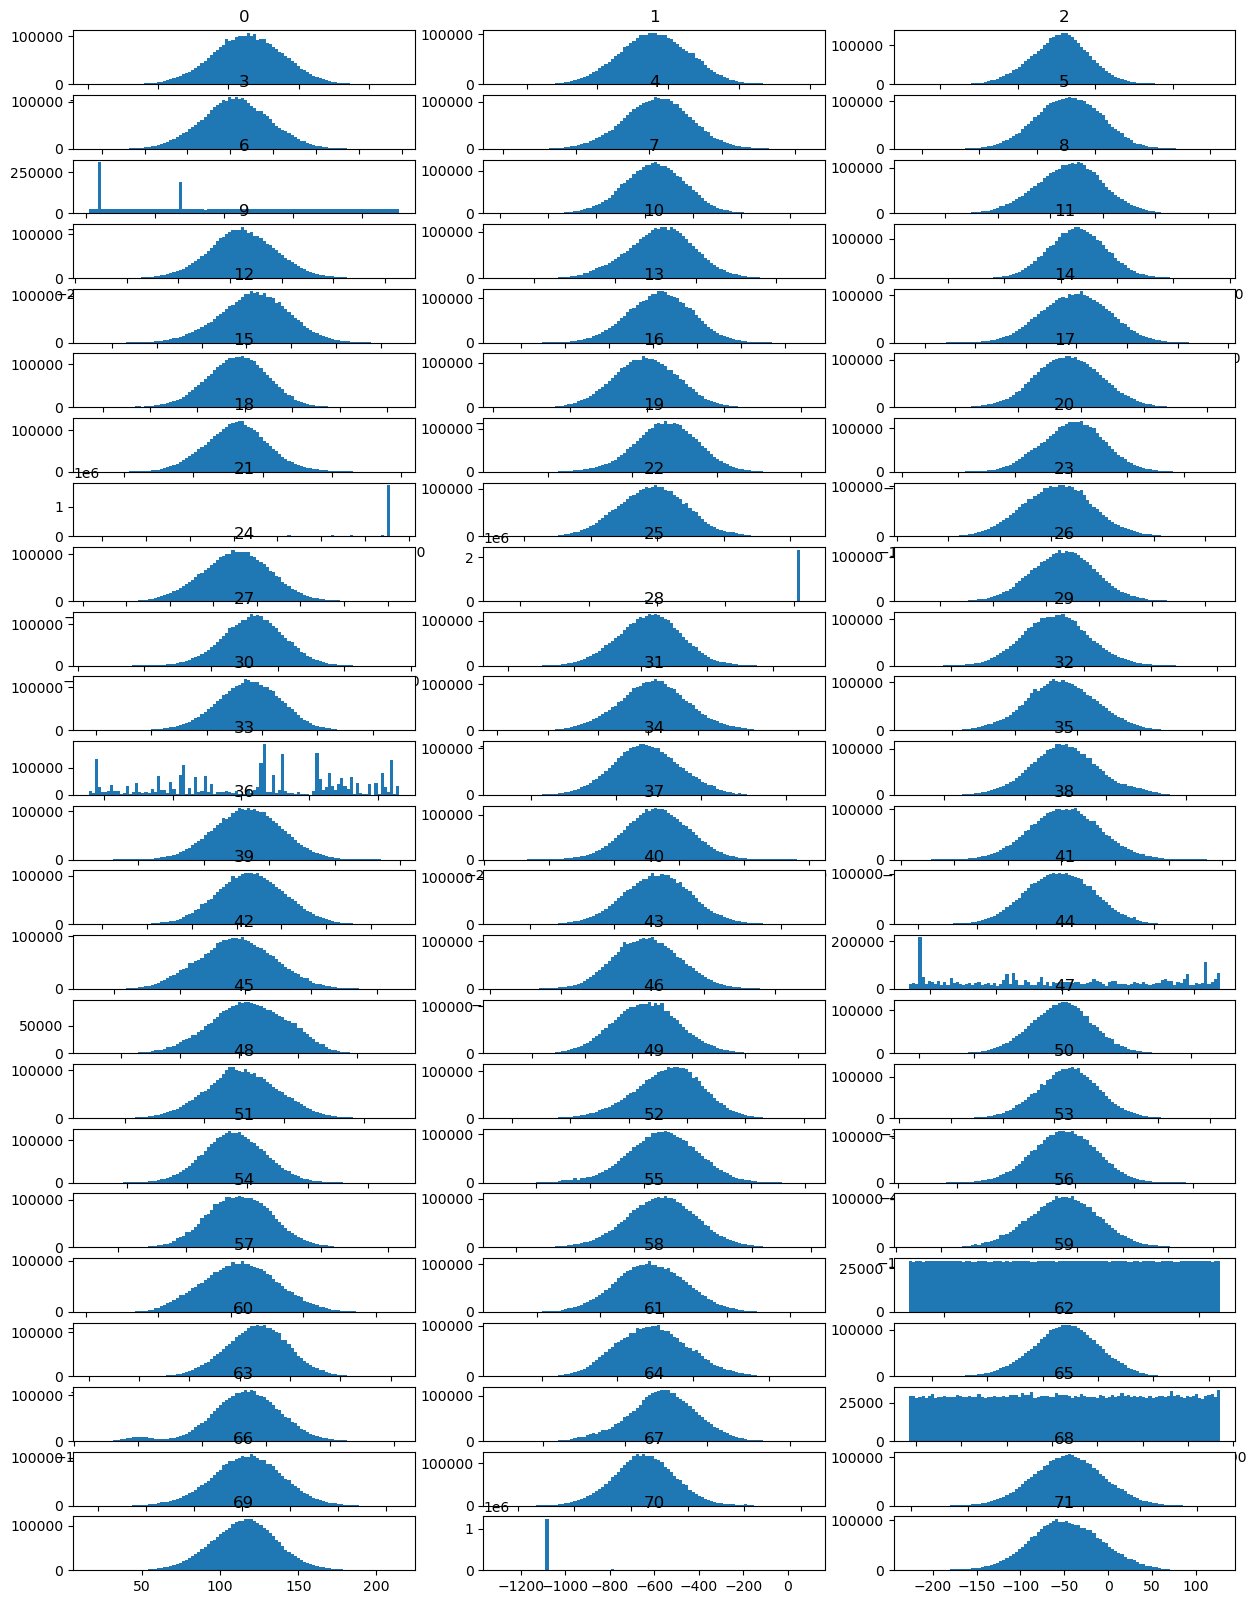

In [6]:
plt.figure(figsize=(15,20))
for i in range(df_base.shape[1]):
    plt.subplot(dims//3, 3, i+1)
    plt.hist(df_base[str(i)], bins=100)
    plt.title(i)
plt.show()

Почти все признаки имеют распределения, похожие на нормальное. Но есть некоторые, которые больше похожи на шум (33, 44, 59, 65), есть с очень неравномерным распределением и узкими аномальными пиками (6, 21, 25, 70).

Посмотрим есть ли там линейная корреляция

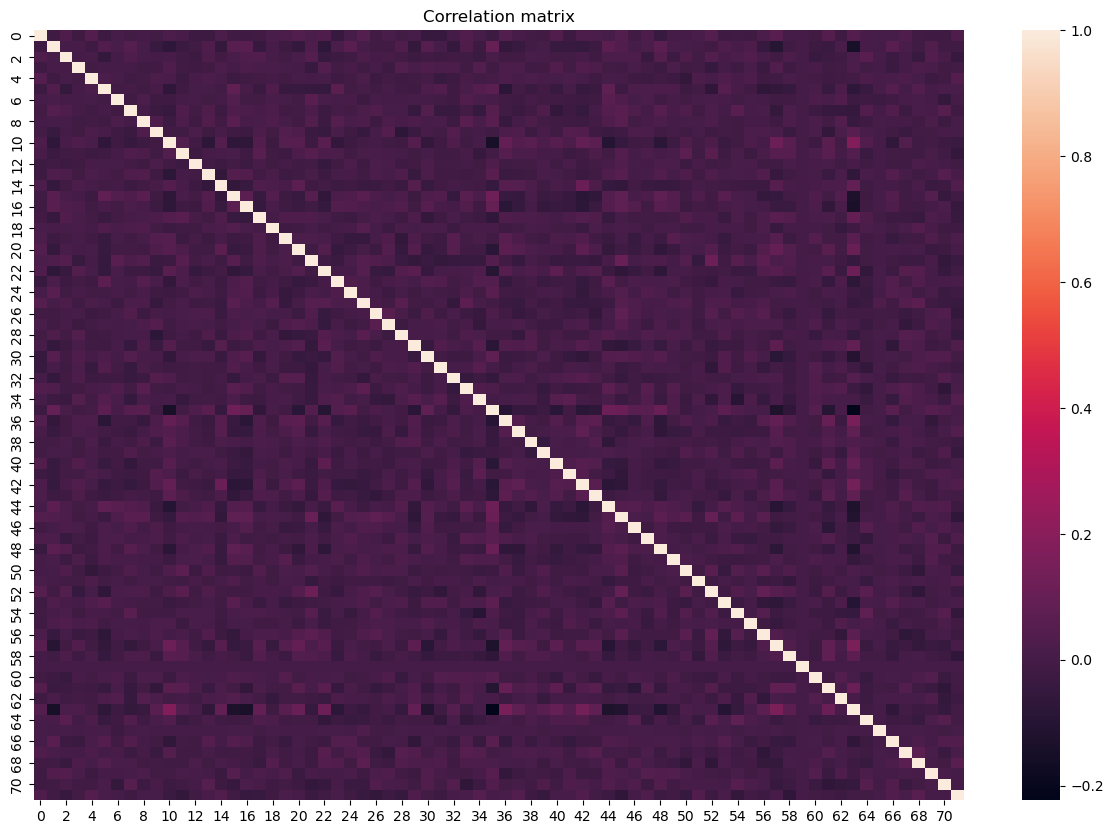

In [7]:
plt.figure(figsize=(15,10))
sns.heatmap(df_base.corr())
plt.title('Correlation matrix')
plt.show()

Никакой.

## Корректировка набора признаков

### Удаление признаков с аномальными распределениями и шумовых (оставляем только те, которые выглядят нормально)

In [6]:
noise = ['6', '21', '25', '33', '44', '59', '65', '70']
df_base_droped = df_base.drop(noise, axis=1)  
df_train_droped = df_train.drop(noise, axis=1)
df_base_droped.shape

(2918139, 64)

### Нормировка всех признаков

In [7]:
scaler = StandardScaler()
scaler.fit(df_base_droped)
base_sc = scaler.transform(df_base_droped)
train_sc = scaler.transform(df_train_droped)

df_base_sc = pd.DataFrame(base_sc, index = df_base.index, columns = df_base_droped.columns)
df_train_sc = pd.DataFrame(train_sc, index = df_train.index, columns = df_base_droped.columns)
df_base_sc.head()

,0,1,2,3,4,5,7,8,9,10,...,60,61,62,63,64,66,67,68,69,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-1.159216,0.620350,-0.513723,1.398558,2.269043,-1.160385,0.373663,-0.435627,0.884544,0.457647,...,0.006792,-0.847513,1.189049,0.190524,0.073589,-2.262493,-0.510438,0.293004,-0.014051,-0.312329
1-base,2.075715,1.060423,-0.652491,-1.002705,-1.157244,-0.500495,-0.871900,-0.623903,1.098487,0.044024,...,1.221724,-1.871023,-1.272135,0.270119,-0.073569,0.225102,0.014491,1.711283,0.059848,-0.281052
2-base,1.285417,-0.343342,0.397878,0.666228,0.853956,-0.973671,0.654489,0.828686,0.619635,0.055584,...,-0.586374,-0.417020,0.086191,0.440159,-1.269686,-1.220546,0.773022,0.099669,0.048521,0.365623
3-base,-0.051852,-0.816047,-1.118829,-1.936660,-0.754014,0.461441,-0.840347,-0.259958,0.182763,0.831647,...,-0.394438,-1.949926,0.274980,-1.372853,0.184217,-0.871349,-0.797073,1.014714,0.090076,-0.601807
4-base,0.541780,-0.314538,2.284450,0.303705,-2.276181,-1.422075,0.386656,-0.238677,-0.191508,0.786741,...,-0.570116,0.559135,0.716557,0.808178,-0.110496,-0.562342,-0.470720,-0.157210,0.920175,1.152406


### Удаление признаков с низкой значимостью

Возьмем часть имеющихся данных и построим модель, предсказывающую ближайший вектор к искомому. Потом посмотрим, есть ли признаки с совсем низкой значимостью и удалим их из всего датасета.

#### Подготовка признаков для классификатора

В качестве признаков для обучения модели, возьмем модуль разности соответствующих координат векторов.

In [8]:
def features_gen(vectors, target): # генерация признаков
    return abs(vectors - target)

Вытаскиваем по номерам векторов сами целевые вектора из тренировочной выборки

In [9]:
target_vec = pd.merge(targets.to_frame(), df_base_droped, right_index=True, left_on='Target')
target_vec.drop('Target', axis=1, inplace=True)

Генерируем признаки для позитивного класса (пометка "1") - находим разность между целевым вектором и ближайшим из базы.

In [10]:
abs_diff_pos = features_gen(df_train_droped, target_vec)# abs(df_train_droped - target_vec) / target_vec
abs_diff_pos['Target'] = 1
abs_diff_pos.head()

,0,1,2,3,4,5,7,8,9,10,...,61,62,63,64,66,67,68,69,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,9.973804,0.808020,9.847884,14.18458,11.353240,9.915970,25.018923,0.85449,13.415337,17.65196,...,3.94519,1.831274,10.210824,4.013000,0.982326,10.934210,22.545300,17.781590,7.762592,1
1-query,0.837820,2.231339,9.354242,32.31715,39.925515,8.301000,59.736948,10.81643,23.579480,58.47786,...,5.26848,36.347542,7.755751,11.047470,2.098824,40.188184,41.332726,29.465650,20.388437,1
10-query,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
100-query,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
1000-query,0.000140,0.000606,0.007618,0.00450,0.015500,0.001786,0.015224,0.00163,0.021370,0.00608,...,0.00059,0.001690,0.006630,0.002894,0.000090,0.006158,0.009706,0.007445,0.003784,1


Генерируем признаки для негативного класса: берем $100$ случайных векторов из train и для каждого из них выбираем $100$ случайных векторов из base. Прогоняем через функцию def features_gen (находим разность этих векторов и целевого вектора), и размечаем данные - у всех отметка "0" (типа, неподходящие вектора)

In [11]:
%%time
dims =  df_train_droped.shape[1]
df_base_notarget = df_base_droped.drop(index=targets.to_list()) #тут все base-вектора, которым нет соответствия в трейне
bad_rand_examples = np.empty((0,dims), dtype=float)
for i in range(100):
    rand_vec = np.ascontiguousarray(df_base_notarget.sample(n=100, random_state=i) #это случайные 100 векторов из базы
                                   .values).astype('float32')
    vec = np.ascontiguousarray(df_train_droped.sample(n=1, random_state=i)
                               .values).astype('float32')
    abs_diff_neg = features_gen(rand_vec, vec) #abs(rand_vec - vec) / vec
    bad_rand_examples = np.concatenate((bad_rand_examples, abs_diff_neg))
    
df_bad_rand_examples = pd.DataFrame(bad_rand_examples, columns=df_base_droped.columns)
df_bad_rand_examples['Target'] = 0 #метка о том, что все эти вектора не подходят
df_bad_rand_examples.head()   
#df_bad_rand_examples.shape

Wall time: 18.5 s


,0,1,2,3,4,5,7,8,9,10,...,61,62,63,64,66,67,68,69,71,Target
0,11.589020,8.500038,21.720985,55.374710,52.802208,6.078911,166.497604,2.575493,206.204437,80.936066,...,6.610352,1.147877,0.284092,21.465752,3.068115,53.170868,59.781330,18.989944,51.154083,0
1,20.637840,9.439420,0.380203,55.821983,22.177971,23.179398,142.568466,7.860497,207.538239,52.805557,...,21.580261,27.862617,18.636826,78.457054,1.327904,50.097343,12.874474,15.652939,13.371651,0
2,37.380203,0.373593,36.995850,35.782257,11.854912,45.051384,55.861732,2.649498,185.540970,86.067780,...,3.741608,51.569614,41.918888,17.973763,2.692101,57.893074,44.372894,3.780319,9.312111,0
3,11.825294,5.626246,49.093468,1.500671,57.169456,19.843056,118.756569,6.936668,140.329056,64.220505,...,3.195511,69.752838,56.506268,1.629112,5.142471,54.034050,119.907722,12.534531,28.437187,0
4,26.495136,9.296824,7.469719,24.834198,101.547356,6.541519,49.533443,5.157524,86.149872,23.516678,...,0.655106,32.149921,36.882046,44.194588,3.603630,145.154312,69.789406,13.654671,98.213043,0


Соединяем отрицательный и положительный датасеты для обучения классификатора. Перемешиваем их.

In [12]:
df_clsfc_rand = pd.concat([df_bad_rand_examples, abs_diff_pos.sample(n=100)]) #случайно вытащили нужное количество положительных классов и склеили с отрицательными
df_clsfc_rand = shuffle(df_clsfc_rand) # все перемешали
#df_clsfc_rand.shape
df_bad_rand_examples.shape

(10000, 65)

Делим выборку на трейн и тест

In [13]:
features_clsfc = df_clsfc_rand.drop('Target', axis = 'columns')
target_clsfc = df_clsfc_rand['Target']

X_train, X_test, y_train, y_test = train_test_split(features_clsfc, target_clsfc, test_size=0.2, stratify=target_clsfc, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) # проверка


(8080, 64) (2020, 64) (8080,) (2020,)


#### Обучение классификатора

In [14]:
lgbm_model = LGBMClassifier(random_state=15)
param_lgbm = {
    'num_leaves': range(2, 30, 5),
    'max_depth': range(5, 30, 5),
    'n_estimators': range(20, 1000, 50)
#    'class_weight': 'balanced'
}

RS_lgbm = RandomizedSearchCV(lgbm_model,
                        param_distributions = param_lgbm,
                        n_jobs=-1,
                        cv=5
)

RS_lgbm.fit(X_train, y_train)
lgbm_score = RS_lgbm.best_score_

print('best params:',RS_lgbm.best_params_)
print('LGBM best score:',RS_lgbm.best_score_)

best params: {'num_leaves': 2, 'n_estimators': 270, 'max_depth': 15}
LGBM best score: 0.998019801980198


In [15]:
#на тесте проверим на всякий случай
RS_lgbm.score(X_test, y_test)

0.996039603960396

Посмотрим рейтинг признаков по важности

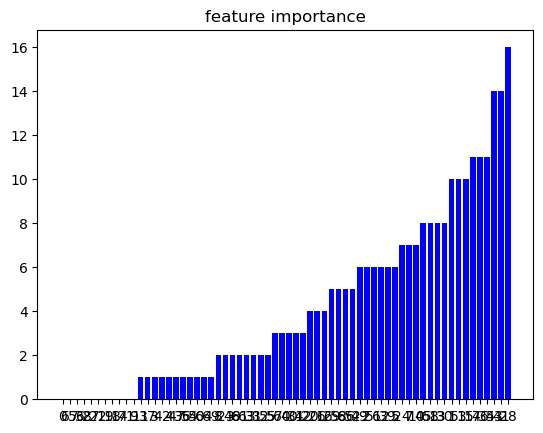

In [16]:
lgbm_importances = pd.DataFrame([X_train.columns, RS_lgbm.best_estimator_.feature_importances_]).T.sort_values(by=1)
plt.bar(lgbm_importances[0], lgbm_importances[1], color='blue', label='LGBM')
plt.title('feature importance')
plt.show()

Исходя из гистограммы, есть признаки, разность которых имеет очень незначительную важность. Вот их то мы и удалим.

#### Удаление признаков из базы и трейна

In [17]:
low_importance = lgbm_importances.head(5)[0].to_list() #это признаки ['64', '49', '45', '43', '12']
df_base_lowimp = df_base_sc.drop(low_importance, axis=1)
df_train_lowimp = df_train_sc.drop(low_importance, axis=1)
df_base_lowimp.shape

(2918139, 59)

## FAISS

Функция, которая обучает индексы и выдает точность

In [18]:
def acc_faiss(n_cells, neighb, nprobe, df_base, df_train, targets):
    dims = df_base.shape[1]
    quantizer = faiss.IndexFlatL2(dims)
    idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)
    idx_l2.train(np.ascontiguousarray(df_base.values[:50000, :]).astype('float32'))
    idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))
    idx_l2.nprobe = nprobe
    base_index = {k: v for k, v in enumerate(df_base.index.to_list())}
    vecs, idx = idx_l2.search(np.ascontiguousarray(df_train.values).astype('float32'), neighb)
    acc = 0
    for target, el in zip(targets.values.tolist(), idx.tolist()):
        acc += int(target in [base_index[r] for r in el])
    return 100 * acc / len(idx), vecs, idx

### Результаты для разной предобработки

Сравним результаты на датасетах с разной корректировкой (исходный, с удаленными фичами, нормированными и удаленными "малозначимыми" признаками)

In [19]:
acc_raw = acc_faiss(100, 10, 1, df_base, df_train, targets)[0]
acc_droped = acc_faiss(100, 10, 1, df_base_droped, df_train_droped, targets)[0]
acc_scaled = acc_faiss(100, 10, 1, df_base_sc, df_train_sc, targets)[0]
acc_lowimp =  acc_faiss(100, 10, 1, df_base_lowimp, df_train_lowimp, targets)[0]

print ('Raw dataset accuracy', acc_raw)
print ('Droped dataset accuracy', acc_droped)
print ('Droped and scaled dataset accuracy', acc_scaled)
print ('Droped and scaled and high-importance dataset accuracy', acc_lowimp)

Raw dataset accuracy 7.95
Droped dataset accuracy 62.136
Droped and scaled dataset accuracy 64.948
Droped and scaled and high-importance dataset accuracy 64.408


Лучше всего - отнормированный датасет с удаленным "шумом".

### Влияние входных параметров фаисса на результат

Зависимость от числа кластеров

In [20]:
accs = []
for i in range(10, 501, 5):
    acc_scaled = acc_faiss(i, 5, 1, df_base_sc, df_train_sc, targets)[0]
    accs.append([i, acc_scaled])
accs_nclust = pd.DataFrame(accs, columns=['i', 'accuracy'])

In [22]:
accs = []
for i in range(1, 18, 2):
    acc_scaled = acc_faiss(i, 5, 1, df_base_sc, df_train_sc, targets)[0]
    accs.append([i, acc_scaled])
accs_nclust0 = pd.DataFrame(accs, columns=['i', 'accuracy'])

Зависимость от nprobe

In [26]:
accs = []
for i in (2**p for p in range(0, 7)):
    acc_scaled = acc_faiss(200, 100, i, df_base_sc, df_train_sc, targets)[0]
    accs.append([i, acc_scaled])
accs_nprobe = pd.DataFrame(accs, columns=['i', 'accuracy'])

Зависимость от числа соседей

In [27]:
accs_n = []
for n in range(5, 200, 5):
    acc_n = acc_faiss(100, n, 1, df_base_sc, df_train_sc, targets)[0]
    accs_n.append([n, acc_n])
accs_n_table = pd.DataFrame(accs_n, columns=['n', 'accuracy'])

In [28]:
accs_n = []
for n in range(250, 500, 50):
    acc_n = acc_faiss(100, n, 1, df_base_sc, df_train_sc, targets)[0]
    accs_n.append([n, acc_n])
accs_n_table1 = pd.DataFrame(accs_n, columns=['n', 'accuracy'])

Поглядим на графики

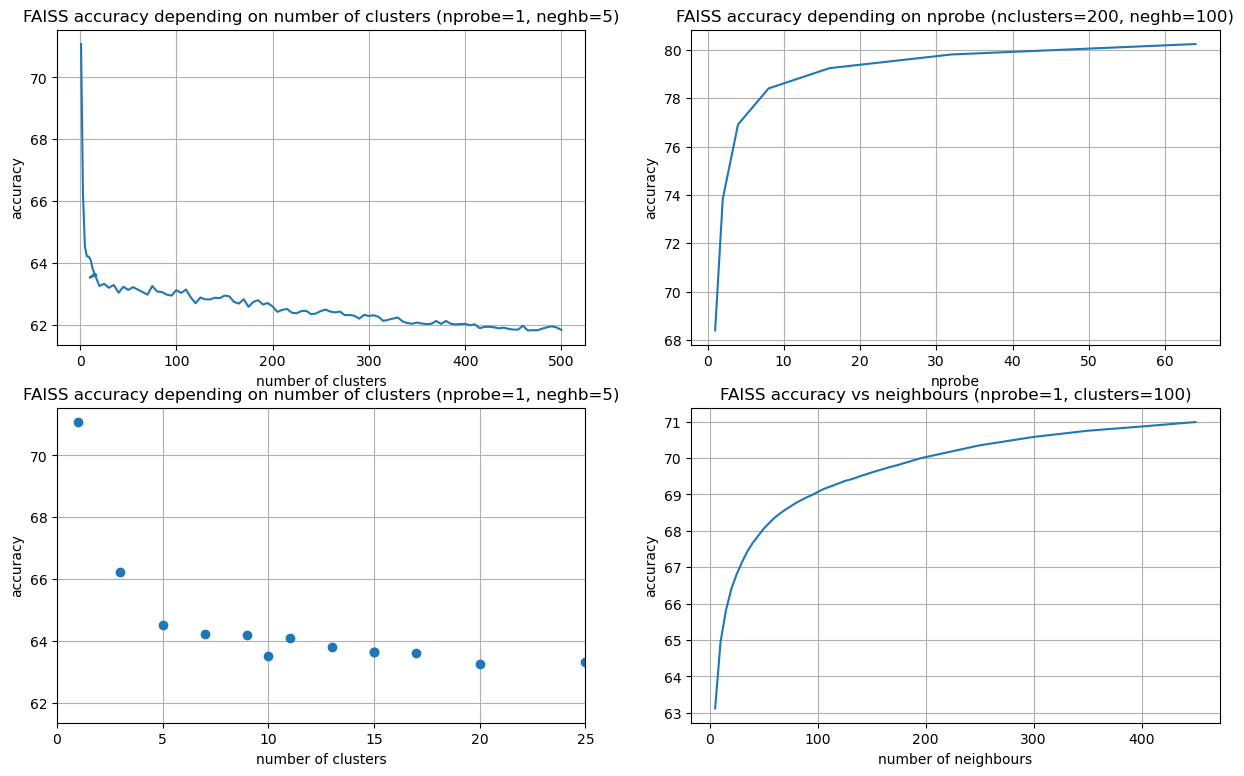

In [32]:
accs_nclusters = pd.concat([accs_nclust0, accs_nclust])
accs_neigb  = pd.concat([accs_n_table, accs_n_table1])

plt.figure(figsize=(15,9))
plt.subplot(2,2,1)
plt.plot(accs_nclusters['i'], accs_nclusters['accuracy'])
plt.title('FAISS accuracy depending on number of clusters (nprobe=1, neghb=5)')
plt.xlabel('number of clusters')
plt.ylabel('accuracy')
plt.grid()
plt.subplot(2,2,2)
plt.plot(accs_nprobe['i'], accs_nprobe['accuracy'])
plt.title('FAISS accuracy depending on nprobe (nclusters=200, neghb=100)')
plt.xlabel('nprobe')
plt.ylabel('accuracy')
plt.grid()
plt.subplot(2,2,3)
plt.plot(accs_nclusters['i'], accs_nclusters['accuracy'], 'o')
plt.title('FAISS accuracy depending on number of clusters (nprobe=1, neghb=5)')
plt.xlabel('number of clusters')
plt.ylabel('accuracy')
plt.xlim(0, 25)
plt.grid()
plt.subplot(2,2,4)
plt.plot(accs_neigb['n'],  accs_neigb['accuracy'])
plt.title('FAISS accuracy vs neighbours (nprobe=1, clusters=100)')
plt.xlabel('number of neighbours')
plt.ylabel('accuracy')
plt.grid()
plt.show()
plt.show()

Исходя их графиков, выбираем следующие параметры для фаисса:
clusters = 50, neghb = 400, nprobe = 40

In [33]:
%%time
faiss_slow = acc_faiss(50, 400, 40, df_base_sc, df_train_sc, targets)
faiss_slow[0]

Wall time: 39min 37s


83.948

Ради интереса посмотрим, как сочетаются время выполнения и точность при различных входных параметрах

In [219]:
%%time
faiss15_400_30 = acc_faiss(200, 400, 30, df_base_sc, df_train_sc, targets)
faiss15_400_30[0]

Wall time: 6min 25s


82.629

In [237]:
%%time
faiss300_400_40 = acc_faiss(300, 400, 40, df_base_sc, df_train_sc, targets)
faiss300_400_40[0]

Wall time: 7min 30s


82.606

In [241]:
%%time
faiss50_100_40 = acc_faiss(50, 100, 40, df_base_sc, df_train_sc, targets)
faiss50_100_40[0]

Wall time: 34min 33s


80.72

In [37]:
faiss15_5 = acc_faiss(15, 5, 10, df_base_sc, df_train_sc, targets)

In [38]:
faiss15_5[0]

71.047

In [246]:
%%time
faiss_test = acc_faiss(500, 100, 1, df_base_sc, df_train_sc, targets)
faiss_test[0]

Wall time: 18.2 s


67.302

Вывод: точности 82.6%  можно достичь на 400 соседях, довольно быстро при количестве кластеров 200 и nprobe = 300. При большом желании можно дотянуть точность до 84%, но это уже по времени дольше почти на порядок (параметры 50, 400 и 40)

## Обучаем классификатор, чтобы отобрать топ-5 из выбранных фаисом

### подготовка признаков

 Из base вытаскиваем вектора, которые подобраны в качестве ответов к тренировочной выборке (по ID)

In [34]:
target_vec = pd.merge(targets.to_frame(), df_base_sc, right_index=True, left_on='Target')
target_vec.drop('Target', axis=1, inplace=True)

Функция, которая генерирует признаки на основе датафрейма с набором векторов и целевого вектора. Эти признаки будут скормлены модели.

In [35]:
def features_gen(vectors: pd.core.frame.DataFrame, target:pd.core.frame.DataFrame) -> np.ndarray:
    features = abs(vectors - target)
    return np.ascontiguousarray(features.values).astype('float32') 

Генерируем признаки для позитивного класса (пометка "1") - находим разность между целевым вектором и ближайшим из базы.

In [36]:
features_pos = features_gen(df_train_sc, target_vec)
df_features_pos = pd.DataFrame(features_pos, columns=df_base_sc.columns)
df_features_pos['Target'] = 1
df_features_pos.head()

,0,1,2,3,4,5,7,8,9,10,...,61,62,63,64,66,67,68,69,71,Target
0,0.400694,0.163125,0.254918,0.714776,0.244956,0.351804,0.389603,0.134436,0.208214,0.423437,...,0.412286,0.060128,0.353487,0.097334,0.538746,0.197574,0.367517,0.839737,0.185939,1
1,0.033659,0.450467,0.242139,1.628495,0.861428,0.294507,0.930245,1.701738,0.365967,1.402772,...,0.550574,1.193428,0.268495,0.267952,1.151078,0.726176,0.673775,1.391518,0.488369,1
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1
4,0.000006,0.000122,0.000197,0.000227,0.000334,0.000063,0.000237,0.000256,0.000332,0.000146,...,0.000062,0.000055,0.000230,0.000070,0.000049,0.000111,0.000158,0.000352,0.000091,1


Возьмем для каждого вектора найденные 400 штук векторов и нагенерируем фичи (разность этих векторов и целевого вектора), сделаем датасет из всего этого с отметкой "0" (типа, неподходящие вектора)

In [74]:
%%time

base_IDs =  np.ascontiguousarray(df_base_sc.index) 

def features_gen(vectors: np.ndarray, target: np.ndarray) -> np.ndarray:
    features = abs(vectors - target)
    return features

#для того, чтобы не использовать целиком всю выборку (слишком тяжелая)
#сгенерируем случайных индексов. Их в 100 раз меньше, чем элементов на входе в тестовой выборке.
idx_rand = np.random.randint(train_sc.shape[0], size=int(df_train_sc.shape[0]*0.01)) 

dims =  df_train_droped.shape[1]
features_neg = np.array([], dtype=np.float32).reshape(0,dims)
base_sc = np.ascontiguousarray(df_base_sc.values).astype('float32')
train_sc = np.ascontiguousarray(df_train_sc.values).astype('float32')[idx_rand]
targets_cut = targets[idx_rand]

for neighb100_idx, target, vec in zip(faiss_slow[2], targets, train_sc):
    target_idx = int(target[:-5])    #номер целевого вектора
    
    try:
        indices = np.where(neighb100_idx==target_idx)
        neighb100_idx = np.delete(neighb100_idx, indices)    #если вдруг faiss нашел целевой вектор - убрать его из соседей
    except:
        pass
    
    neighb10 = base_sc[neighb100_idx] #[:10]] #нашли по индексам сами векторы - соседи.10 штук.
    each_vec_features_neg = features_gen(neighb100, vec) #сгенерировали из них "негативные" фичи - разность с целевым вектором  
    
    features_neg = np.concatenate((features_neg, each_vec_features_neg)) #прилепили к фичам из предыдущих итераций
    
    
df_features_neg = pd.DataFrame(features_neg, columns=df_base_sc.columns)  #сшиваем все в один датафрейм
df_features_neg['Target'] = 0 #метка о том, что все эти вектора не подходят
df_features_neg.head()

Wall time: 38 s


,0,1,2,3,4,5,7,8,9,10,...,61,62,63,64,66,67,68,69,71,Target
0,0.787933,1.461295,0.098869,2.085646,2.208910,0.849546,0.254694,0.322300,1.659610,0.882265,...,2.790992,0.423032,1.656131,0.572374,0.405688,1.592947,0.005658,0.624829,0.451088,0
1,0.448561,1.596393,0.635439,1.439270,2.174104,0.914777,0.611341,0.213772,2.295515,0.776341,...,3.080842,0.721125,1.347370,0.348438,0.614995,1.098050,0.519478,0.425727,0.888199,0
2,0.616883,2.200089,0.386202,2.526721,2.318380,0.672241,0.242951,0.586440,1.469051,0.617162,...,3.172706,0.266704,1.415318,0.153824,0.240274,1.469739,0.576986,0.583550,1.082567,0
3,0.333777,1.225361,0.162492,1.769236,2.291680,0.845954,0.557453,0.603216,1.878559,0.677022,...,3.051192,0.290769,1.348899,0.687110,0.597554,1.516655,0.578148,0.589798,1.002634,0
4,0.973281,1.605811,0.077869,2.114235,2.744761,0.945048,0.684392,0.614230,2.125759,0.247821,...,3.044866,0.212225,1.065413,0.037585,0.428468,1.156815,0.758239,0.324959,0.453728,0


Соединяем отрицательный и положительный датасеты для обучения классификатора

In [76]:
df_clsfc = pd.concat([df_features_neg, df_features_pos])
df_clsfc = shuffle(df_clsfc) # все перемешали
df_clsfc.shape

(500000, 65)

In [77]:
# почистим память от переменных
del df_features_neg
del df_features_pos

### Делим признаки на тренировочные и тестовые

In [78]:
#df_clsfc.sample(n=)
features_clsfc = df_clsfc.drop('Target', axis = 'columns')
target_clsfc = df_clsfc['Target']

X_train, X_test, y_train, y_test = train_test_split(features_clsfc, target_clsfc, test_size=0.2, stratify=target_clsfc, random_state=1)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape) # проверка

del df_clsfc

(400000, 64) (100000, 64) (400000,) (100000,)


### Обучение модели

#### LGBM 

In [83]:
%%time
lgbm_model = LGBMClassifier(class_weight={0: 400., 1: 1.}, random_state=15)
param_lgbm = {
    'num_leaves': range(2, 20, 5),
    'max_depth': range(10, 30, 5),
    'n_estimators': range(20, 500, 50)
}

RS_lgbm = RandomizedSearchCV(lgbm_model,
                        param_distributions = param_lgbm,
                        n_jobs=-1,
                        cv=5
)

RS_lgbm.fit(X_train, y_train)
lgbm_score = RS_lgbm.best_score_

print('best params:',RS_lgbm.best_params_)
print('LGBM best score:',RS_lgbm.best_score_)

best params: {'num_leaves': 17, 'n_estimators': 20, 'max_depth': 20}
LGBM best score: 0.9591875
Wall time: 9min 58s


In [84]:
#на тесте проверим на всякий случай
RS_lgbm.score(X_test, y_test)

0.95462

#### Catboost

In [ ]:
%%time
CB_model = CatBoostClassifier(verbose=False, random_state=15)

param_CB = {
    'iterations': range(58, 64, 2),
    'learning_rate': np.arange(0.05, 0.06, 0.005),
    'depth': range(14, 16, 1)
}

RS_CB = RandomizedSearchCV(CB_model,
                        param_distributions = param_CB,
                        n_jobs=-1,
                        cv=5
)

RS_CB.fit(X_train, y_train)
#CB_score = CB_model.best_score_

print('best params:',RS_CB.best_params_)
print('CatBoost best score:', RS_CB.best_score_)

In [123]:
#на тесте проверим на всякий случай
RS_CB.score(X_test, y_test)

0.98181

### Соединяем две модели

In [127]:
%%time
lr = LogisticRegression() # defining meta-classifier
clf_stack = StackingClassifier(classifiers =[RS_CB, RS_lgbm], meta_classifier = lr, use_probas = True, use_features_in_secondary = True)
model_stack = clf_stack.fit(X_train, y_train) # training of stacked model
pred_stack = model_stack.predict(X_test)	 # predictions on test data using stacked model
acc_stack = accuracy_score(y_test, pred_stack)
print ('точность стека', acc_stack)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


точность стека 0.98303


## Проверка работы на тестовых данных.

### Загрузка и предобработка данных

In [85]:
df_val = pd.read_csv('validation.csv')
df_val_targetsId = pd.read_csv('validation_answer.csv')
df_val.head()

,Id,0,1,2,3,4,5,6,7,8,...,62,63,64,65,66,67,68,69,70,71
0,100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
1,100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
2,100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
3,100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
4,100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


In [86]:
df_val_targetsId.head()

,Id,Expected
0,100000-query,2676668-base
1,100001-query,91606-base
2,100002-query,472256-base
3,100003-query,3168654-base
4,100004-query,75484-base


Колонки Id совпадают в df_val и df_val_targets?

In [87]:
sum(df_val['Id'] != df_val_targetsId['Id'])

0

In [88]:
df_val_targetsId.drop(['Id'], axis=1, inplace=True)
val_targetsId = df_val_targetsId.squeeze()

да! поэтому можно эту колонку выкинуть в обоих датасетах.

дропинг скейлинг и вся фигня 

In [89]:
#noise = ['6', '21', '25', '33', '44', '59', '65', '70']
df_val_droped = df_val.drop(noise + ['Id'], axis=1)  
val_sc = scaler.transform(df_val_droped)
df_val_sc = pd.DataFrame(val_sc, index = df_val.index, columns = df_val_droped.columns)

df_val_sc.head()

,0,1,2,3,4,5,7,8,9,10,...,60,61,62,63,64,66,67,68,69,71
0,1.159310,-0.904901,0.811955,1.043508,-0.012313,-0.329532,1.860318,-1.699665,-0.764269,0.269789,...,1.767701,-1.413223,0.115241,0.676228,0.275453,0.817488,0.693550,0.597167,-0.020121,-1.659674
1,1.304502,0.950910,0.033969,0.615646,0.067603,-0.657373,0.679613,0.540216,-1.107069,-0.253738,...,-0.548876,-1.135690,-0.013756,-0.142350,-0.334949,1.631021,-1.617587,0.360549,0.369533,0.545701
2,0.886027,-2.434901,0.955216,-1.185496,-0.320843,0.341078,1.045290,1.193478,0.690080,-1.851159,...,1.127774,0.402836,-1.831225,0.140946,-0.118026,-0.044550,1.128563,1.021715,1.204944,-0.555197
3,-0.524576,1.623911,1.408637,-0.071830,-0.595916,-2.190385,-0.613543,-1.359610,-0.764409,0.692479,...,0.783558,0.268198,0.058666,0.373992,0.540055,1.695934,0.000596,0.949135,1.307485,-0.996489
4,0.269032,-1.704743,0.739119,-1.221980,1.168059,1.550401,0.218922,0.821217,-0.347213,1.605413,...,0.856405,-0.512342,-1.469227,0.427148,0.498123,1.549868,-0.148400,1.297723,-0.654827,-1.856774


In [90]:
df_val_targets_vec = pd.merge(df_val_targetsId['Expected'], df_base_sc, right_index=True, left_on='Expected')
df_val_targets_vec.drop('Expected', axis=1, inplace=True)
df_val_targets_vec.head()

,0,1,2,3,4,5,7,8,9,10,...,60,61,62,63,64,66,67,68,69,71
0,1.020356,-2.237839,0.267407,0.431866,-0.533111,-0.797379,1.506451,-1.937298,-1.125738,0.186596,...,1.411411,-0.457295,0.082750,0.704080,-0.531969,0.457251,1.216843,1.091280,-0.785043,-1.626359
1,-1.060382,-0.219336,0.579864,0.568762,0.309760,-0.442072,-1.028772,0.364977,-0.893599,-0.133381,...,-0.550550,-0.630130,0.396296,-0.962816,-1.223015,0.992127,0.623803,0.310357,1.522291,0.100351
2,0.886067,-2.434851,0.955174,-1.185629,-0.320852,0.341119,1.045193,1.193327,0.690236,-1.851137,...,1.127726,0.402794,-1.831183,0.140928,-0.118053,-0.044484,1.128726,1.021673,1.204840,-0.555275
3,-0.653081,1.690923,1.508751,-0.090221,-0.721139,-2.140760,-0.609458,-1.343169,-0.849582,0.736096,...,0.855331,0.222372,0.043575,0.328845,0.561700,1.681620,0.073480,0.865355,1.337721,-0.973723
4,0.380710,-1.611984,1.229451,-1.101831,0.952102,1.276331,0.493428,0.486407,-0.567811,1.733293,...,1.047629,-0.412253,-1.095508,0.349702,-0.268689,1.493573,-0.444374,1.861926,-0.518794,-1.480759


###   С помощью Faiss отбираем претендентов

отбираем фаиссом ближайшие 400 соседей

In [91]:
%%time
faiss_val = acc_faiss(50, 400, 40, df_base_droped, df_val_droped, val_targetsId)
faiss_val[0]

Wall time: 36min 45s


82.308

### Отбор топ-5 с помощью классификатора

Генерируем из результатов FAISS и целевых векторов признаки, съедобные для классификатора и для каждого вектора прогоняем классификатор.

для LGBM

In [95]:
%%time

val_sc = np.ascontiguousarray(df_val_sc.values).astype('float32')
val_targets_vec = np.ascontiguousarray(df_val_targets_vec.values).astype('float32')
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

acc = 0

for neighb100_idx, targetID, target, vec in zip(faiss_val[2], val_targetsId, val_targets_vec, val_sc):
    neighb100 = base_sc[neighb100_idx] #нашли по индексам сами векторы - соседи 
    features = features_gen(neighb100, vec)  #сгенерировали из них фичи
    prob = RS_lgbm.predict_proba(features)[:,1]
    top5_feature_idx =  prob.argsort()[-5:][::-1]
    top5_idx = neighb100_idx[top5_feature_idx]
    #top5_vec = base_sc[top5_idx]
    
    acc += int(targetID in [base_index[r] for r in top5_idx])  
        
result = 100 * acc / len(val_sc)
result

Wall time: 2min 11s


48.115

для CatBoost

In [124]:
%%time

acc = 0

for neighb100_idx, targetID, target, vec in zip(faiss_val[2], val_targetsId, val_targets_vec, val_sc):
    neighb100 = base_sc[neighb100_idx] #нашли по индексам сами векторы - соседи 
    features = features_gen(neighb100, vec)  #сгенерировали из них фичи
    prob = RS_CB.predict_proba(features)[:,1]
    top5_feature_idx =  prob.argsort()[-5:][::-1]
    top5_idx = neighb100_idx[top5_feature_idx]
    #top5_vec = base_sc[top5_idx]
    
    acc += int(targetID in [base_index[r] for r in top5_idx])  
        
result = 100 * acc / len(val_sc)
result

Wall time: 3min 46s


65.392

Для stack

In [128]:
%%time

acc = 0

for neighb100_idx, targetID, target, vec in zip(faiss_val[2], val_targetsId, val_targets_vec, val_sc):
    neighb100 = base_sc[neighb100_idx] #нашли по индексам сами векторы - соседи 
    features = features_gen(neighb100, vec)  #сгенерировали из них фичи
    prob = model_stack.predict_proba(features)[:,1]
    top5_feature_idx =  prob.argsort()[-5:][::-1]
    top5_idx = neighb100_idx[top5_feature_idx]
    #top5_vec = base_sc[top5_idx]
    
    acc += int(targetID in [base_index[r] for r in top5_idx])  
        
result = 100 * acc / len(val_sc)
result

Wall time: 5min 14s


53.496

Почему-то для стэкнутого варианта, точность вышла хуже, чем для отдельного катбуста.

## Вывод

Итоговая точность получилась на lgbm 48%, а на Catboost 65% :(